# Importing

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [3]:
random.seed(42)

np.random.seed(42)

tf.random.set_seed(42)

# Plot Function

In [ ]:
def plot_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    val_metrics = [f'val_{m}' for m in metrics if f'val_{m}' in history.history]

    plt.figure(figsize=(12,5))
    
    # ---- LOSS ----
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-') 
    plt.plot(history.history['val_loss'], label='Val Loss', color='red', linestyle='--')  
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # ---- METRIC (AUC atau Accuracy) ----
    plt.subplot(1,2,2)
    if 'auc' in history.history:
        plt.plot(history.history['auc'], label='Train AUC', color='blue', linestyle='-')
        plt.plot(history.history['val_auc'], label='Val AUC', color='red', linestyle='--')
        plt.title('ROC-AUC Curve')
        plt.ylabel('AUC')
    else:
        plt.plot(history.history['accuracy'], label='Train Acc', color='blue', linestyle='-')
        plt.plot(history.history['val_accuracy'], label='Val Acc', color='red', linestyle='--')
        plt.title('Accuracy Curve')
        plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Data Prep

In [11]:
data = np.load("D:\Kuliah\Tugas Akhir\Demo\src\data_preprocessed.npz")

X_train = data["X_train"]
X_test  = data["X_test"]
y_train = data["y_train"]
y_test  = data["y_test"]
vocab_size = int(data["vocab_size"])

# LSTM

In [12]:
def build_model(vocab_size,
                embedding_dim=50,
                n_layers=1,
                units=(16,),
                dropout_rate=0.3,
                lr=0.001):
    
    baseline1 = Sequential()

    # ---- EMBEDDING ----
    baseline1.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    # ---- DYNAMIC LSTM STACK ----
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)  
        baseline1.add(LSTM(units[i], return_sequences=return_seq))
        baseline1.add(Dropout(dropout_rate))

    # ---- DENSE ----
    baseline1.add(Dense(1, activation='sigmoid'))

    # ---- COMPILE ----
    baseline1.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='AUC')]
    )

    return baseline1


## Baseline 1

In [ ]:
# Build model
baseline1 = build_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    n_layers=1,
    units=[128],
    dropout_rate=0.2,  
    lr=0.001
)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('fixed_model.keras', monitor='val_loss', mode='min', save_best_only=True)
]
    
# Fit model
history = baseline1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - AUC: 0.4766 - accuracy: 0.4950 - loss: 0.6930 - val_AUC: 0.6563 - val_accuracy: 0.6016 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - AUC: 0.6235 - accuracy: 0.5917 - loss: 0.6789 - val_AUC: 0.6586 - val_accuracy: 0.6016 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - AUC: 0.6476 - accuracy: 0.6326 - loss: 0.6643 - val_AUC: 0.6906 - val_accuracy: 0.6328 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - AUC: 0.6650 - accuracy: 0.6116 - loss: 0.6468 - val_AUC: 0.7015 - val_accuracy: 0.6406 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - AUC: 0.6635 - accuracy: 0.6062 - loss: 0.6441 - val_AUC: 0.6839 - val_accuracy: 0.6406 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - AUC: 0.6824 - accuracy: 0.6110 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

=evaluation
ROC-AUC       : 0.7983
Akurasi       : 0.7266

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.73      0.74      0.73        65
   Inhibitor       0.73      0.71      0.72        63

    accuracy                           0.73       128
   macro avg       0.73      0.73      0.73       128
weighted avg       0.73      0.73      0.73       128



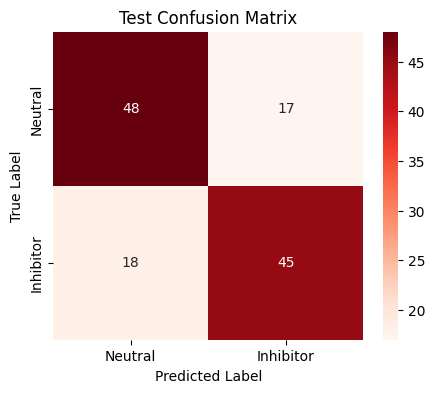

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


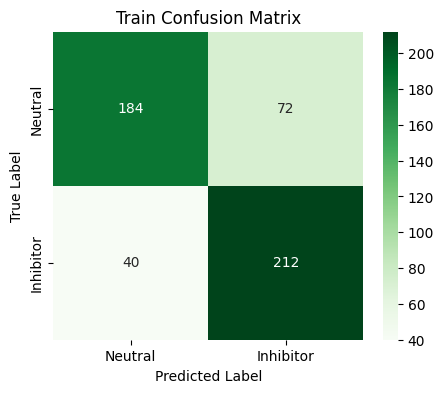

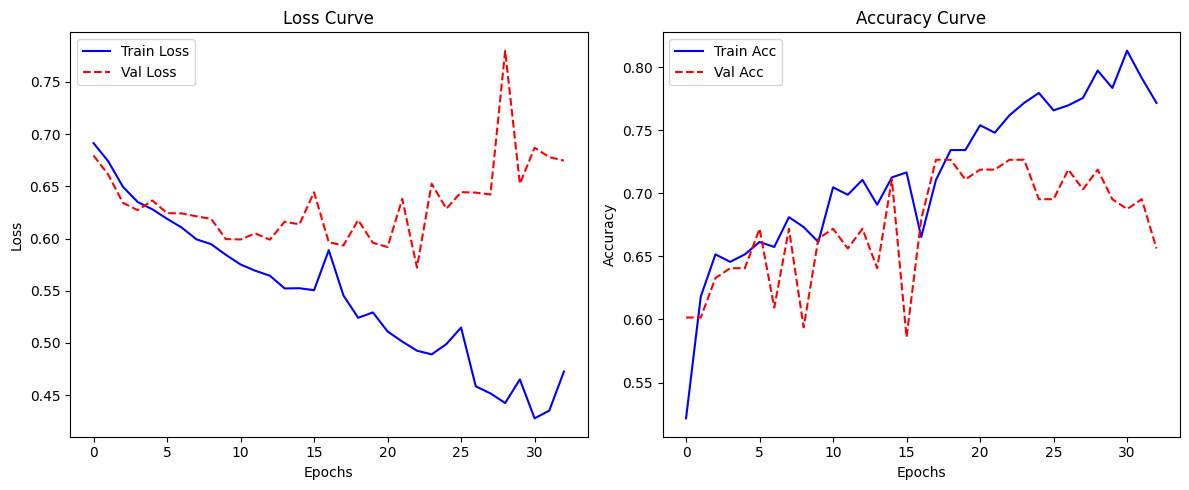

In [ ]:
# ====== TEST CONFUSION MATRIX ======
y_pred_prob = baseline1.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',  
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = baseline1.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()

plot_history(history)

# Baseline 2

In [16]:
# Build model
baseline2 = build_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    n_layers=2,
    units=[128, 64],
    dropout_rate=0.3,  
    lr=0.001
)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('fixed_model.keras', monitor='val_loss', mode='min', save_best_only=True)
]
    
# Fit model
history = baseline2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - AUC: 0.4825 - accuracy: 0.4834 - loss: 0.6931 - val_AUC: 0.6540 - val_accuracy: 0.5859 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - AUC: 0.5986 - accuracy: 0.5564 - loss: 0.6837 - val_AUC: 0.6701 - val_accuracy: 0.5859 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - AUC: 0.6322 - accuracy: 0.6116 - loss: 0.6694 - val_AUC: 0.6841 - val_accuracy: 0.6016 - val_loss: 0.6529 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - AUC: 0.6460 - accuracy: 0.6218 - loss: 0.6629 - val_AUC: 0.6979 - val_accuracy: 0.6094 - val_loss: 0.6228 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - AUC: 0.6685 - accuracy: 0.6053 - loss: 0.6406 - val_AUC: 0.6916 - val_accuracy: 0.6094 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - AUC: 0.6896 - accuracy: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step

=evaluation
ROC-AUC       : 0.7062
Akurasi       : 0.6406

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.67      0.58      0.62        65
   Inhibitor       0.62      0.70      0.66        63

    accuracy                           0.64       128
   macro avg       0.64      0.64      0.64       128
weighted avg       0.64      0.64      0.64       128



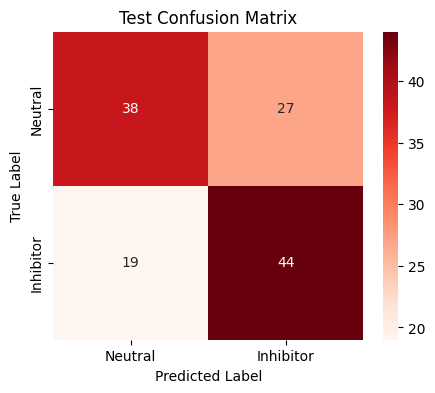

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


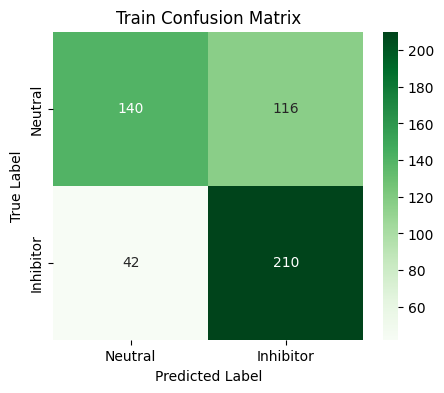

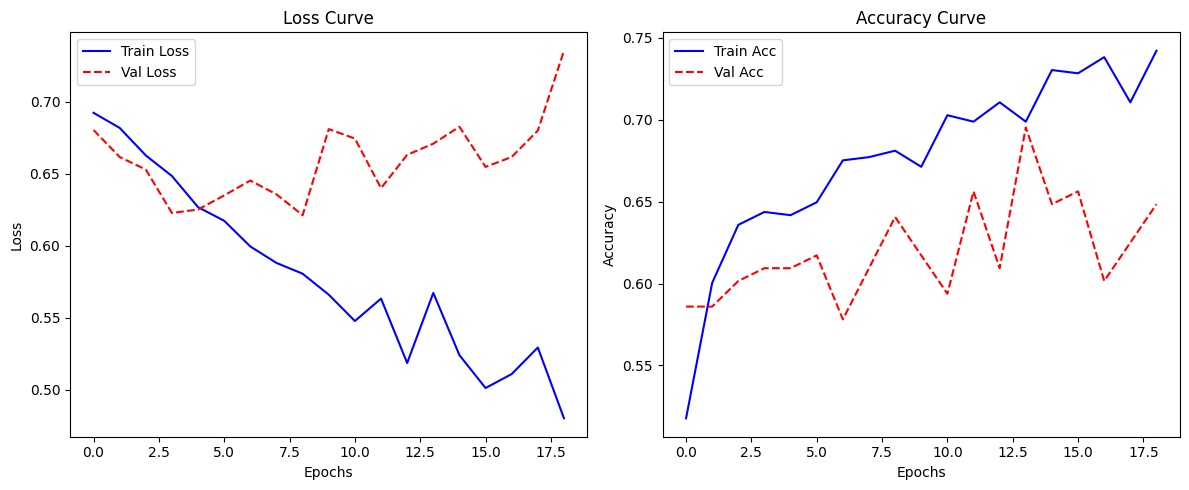

In [ ]:
# ====== TEST CONFUSION MATRIX ======
y_pred_prob = baseline2.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',  # <- ubah jadi merah
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = baseline2.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()

plot_history(history)

## Baseline 3

In [19]:
# Build model
baseline3 = build_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    n_layers=3,
    units=[128, 64, 32],
    dropout_rate=0.4,  
    lr=0.001
)

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('fixed_model.keras', monitor='val_loss', mode='min', save_best_only=True)
]
    
# Fit model
history = baseline3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50, 
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - AUC: 0.4400 - accuracy: 0.4719 - loss: 0.6940 - val_AUC: 0.6094 - val_accuracy: 0.5938 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - AUC: 0.5450 - accuracy: 0.4828 - loss: 0.6916 - val_AUC: 0.6350 - val_accuracy: 0.5859 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - AUC: 0.6269 - accuracy: 0.5952 - loss: 0.6797 - val_AUC: 0.6451 - val_accuracy: 0.5938 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - AUC: 0.6282 - accuracy: 0.6164 - loss: 0.6727 - val_AUC: 0.6643 - val_accuracy: 0.5938 - val_loss: 0.6549 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - AUC: 0.6383 - accuracy: 0.6061 - loss: 0.6649 - val_AUC: 0.6996 - val_accuracy: 0.6328 - val_loss: 0.6316 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - AUC: 0.6715 - accuracy: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

=evaluation
ROC-AUC       : 0.7214
Akurasi       : 0.6406

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.67      0.57      0.62        65
   Inhibitor       0.62      0.71      0.66        63

    accuracy                           0.64       128
   macro avg       0.64      0.64      0.64       128
weighted avg       0.65      0.64      0.64       128



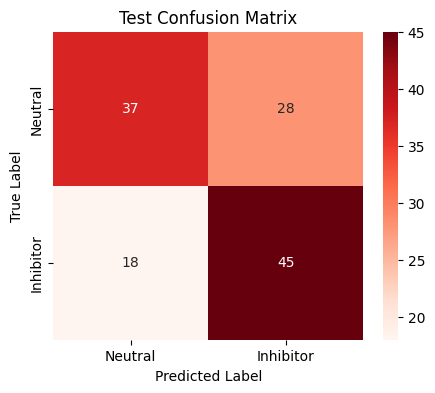

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


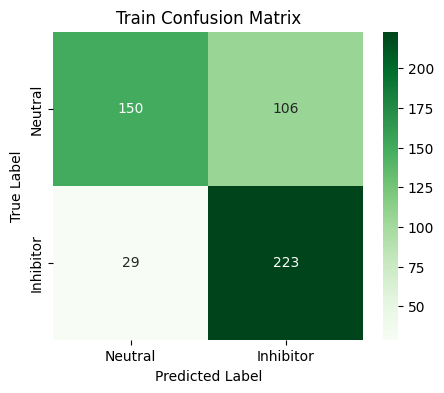

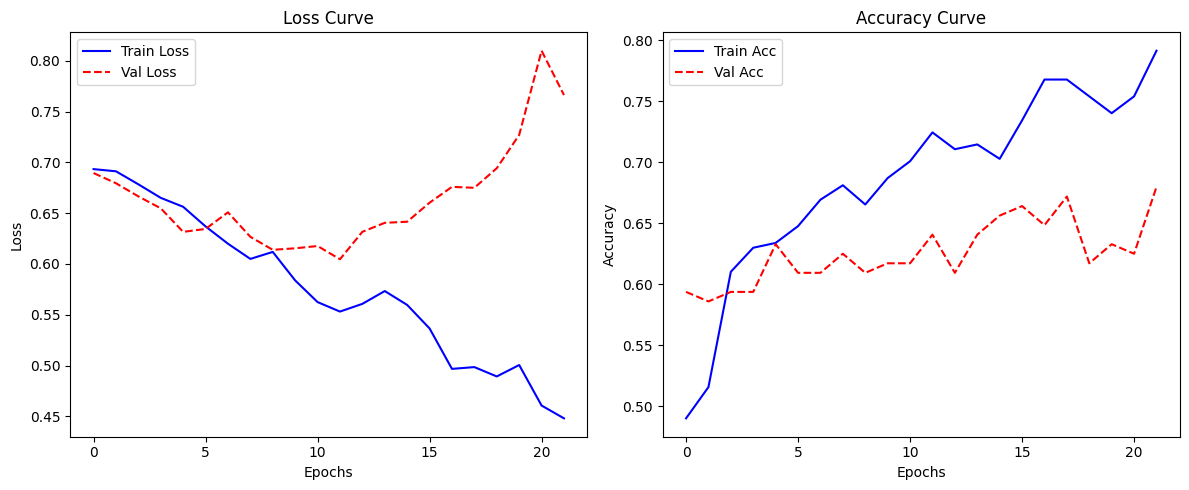

In [ ]:
# ====== TEST CONFUSION MATRIX ======
y_pred_prob = baseline3.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n=evaluation")
print(f"ROC-AUC       : {roc_auc:.4f}")
print(f"Akurasi       : {np.mean(y_pred == y_test):.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

cm_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',  
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Test Confusion Matrix')
plt.show()

# ====== TRAIN CONFUSION MATRIX ======
y_pred_train_prob = baseline3.predict(X_train).flatten()
y_pred_train = (y_pred_train_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Train Confusion Matrix')
plt.show()

plot_history(history)